# Importing Librarires

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer

## Loading Data

In [245]:
train = pd.read_csv('train.csv')
train.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
train.shape

(8523, 12)

In [7]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [14]:
corr_metric = train.corr()

In [16]:
corr_metric['Item_Outlet_Sales'].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64

In [246]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [19]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [165]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [243]:
categoricals = ['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Type','Outlet_Size','Outlet_Establishment_Year']
        
for col in categoricals:
    print('testing')
    if train[col].isnull().sum() != 0:
        print(col)
        train[col].fillna(train[col].mode().values[0],inplace=True)

testing
testing
testing
testing
testing
Outlet_Size
testing


In [232]:
train['Outlet_Establishment_Year'].isnull().sum() != 0

False

## Converting Outlet Establishment years in intervals

In [264]:
from sklearn.base import BaseEstimator,TransformerMixin
class categorical_transformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        temp = X.copy()
        # removing any nan values from categorical features
        categoricals = ['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Type','Outlet_Size','Outlet_Establishment_Year']
        for col in categoricals:
            if temp[col].isnull().sum() != 0:
                temp[col] = temp[col].fillna(temp[col].mode().values[0])
                
                
        
        # making intervals in year of establishment
        temp['Outlet_Establishment_Year']=pd.cut(temp['Outlet_Establishment_Year'],bins=[0,1985,1990,1995,2000,2005,np.inf],labels=['0-1985','1986-1990','1991-1995','1996-2000','2001-2005','2006-2010'])
        
        # removing same category name written differently like regular written as reg of Low Fat as LF or low fat
        fat_content = []
        for val in temp['Item_Fat_Content'].values:
            if val == 'reg':
                fat_content.append('Regular')
            elif val == 'LF' or val=='low fat':
                fat_content.append('Low Fat')
            else:
                fat_content.append(val)
        temp['Item_Fat_Content'] = fat_content
        
        
        return temp

In [265]:
testing_func = categorical_transformer().fit(train).transform(train)

In [266]:
testing_func['Outlet_Establishment_Year'].value_counts()

1996-2000    2415
2001-2005    1859
2006-2010    1854
0-1985       1463
1986-1990     932
1991-1995       0
Name: Outlet_Establishment_Year, dtype: int64

In [267]:
testing_func['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [268]:
testing_func.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## One Hot Encoding

In [198]:
# we are not using ID as features
categoricals = ['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Type','Outlet_Size','Outlet_Establishment_Year']
one_hot_enc = OneHotEncoder()
one_hot_enc.fit(train[categoricals])
cat_enc = one_hot_enc.transform(train[categoricals])

In [59]:
cat_enc.toarray().shape

(8523, 37)

In [60]:
one_hot_enc.categories_

[array(['LF', 'Low Fat', 'Regular', 'low fat', 'reg'], dtype=object),
 array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
        'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
        'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
        'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object),
 array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object),
 array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
        'Supermarket Type3'], dtype=object),
 array(['High', 'Medium', 'Small', nan], dtype=object),
 array(['0-1985', '1986-1990', '1996-2000', '2001-2005', '2006-2010'],
       dtype=object)]

## Applying Imputer

In [61]:
imputer = SimpleImputer(strategy='median')
continous = ['Item_Weight','Item_Visibility','Item_MRP']
imputer.fit(train[continous])
cont_imp = imputer.transform(train[continous])

In [62]:
pd.DataFrame(cont_imp).isnull().sum()

0    0
1    0
2    0
dtype: int64

array([[<AxesSubplot:xlabel='Item_Weight', ylabel='Item_Weight'>,
        <AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Weight'>,
        <AxesSubplot:xlabel='Item_MRP', ylabel='Item_Weight'>],
       [<AxesSubplot:xlabel='Item_Weight', ylabel='Item_Visibility'>,
        <AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Visibility'>,
        <AxesSubplot:xlabel='Item_MRP', ylabel='Item_Visibility'>],
       [<AxesSubplot:xlabel='Item_Weight', ylabel='Item_MRP'>,
        <AxesSubplot:xlabel='Item_Visibility', ylabel='Item_MRP'>,
        <AxesSubplot:xlabel='Item_MRP', ylabel='Item_MRP'>]], dtype=object)

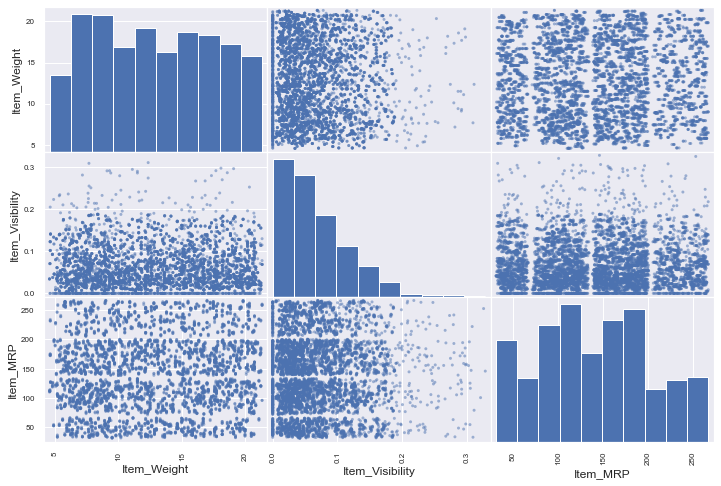

In [63]:
from pandas.plotting import scatter_matrix
scatter_matrix(train[continous],figsize=(12,8))
    

## Creating Pipelines

In [269]:
# pipeline for numerical data
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler())
])

In [270]:
train_num_tr = num_pipeline.fit_transform(train[continous])

In [271]:
train_num_tr

array([[-0.83118663, -0.97073217,  1.74745381],
       [-1.63080955, -0.90811123, -1.48902325],
       [ 1.10872696, -0.95691733,  0.01004021],
       ...,
       [-0.52363935, -0.59978449, -0.89720755],
       [-1.32562802,  1.53287976, -0.60797692],
       [ 0.46997492, -0.41193591, -1.05226104]])

In [272]:
# pipeline for categorical features
cat_pipeline = Pipeline([
    ('attr_convert',categorical_transformer()),
    ('one_hot',OneHotEncoder())
])

In [273]:
cat_pipeline.fit_transform(train[categoricals]).toarray().shape

(8523, 33)

In [274]:
X = train.drop('Item_Outlet_Sales',axis=1)
y = train['Item_Outlet_Sales'].copy()

In [275]:
# full pipeline
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
    ('num',num_pipeline,continous),
    ('cat',cat_pipeline,categoricals)
])

In [276]:
final_data = full_pipeline.fit_transform(X).toarray()

In [277]:
final_data.shape

(8523, 36)

## Applying PCA


In [137]:
from sklearn.decomposition import PCA
pca = PCA(20)

In [138]:
pca.fit(final_data)

PCA(n_components=20)

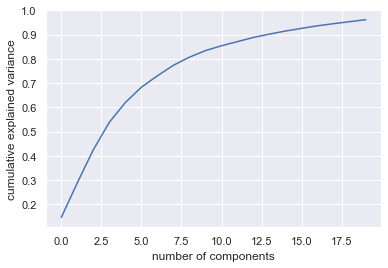

In [142]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [155]:
pca_data = pca.transform(final_data)

## Training Model

In [179]:
# trying with base model
forest_reg = RandomForestRegressor()
forest_reg.fit(final_data,y)

RandomForestRegressor()

In [180]:
forest_reg.score(final_data,y)

0.9378971606019441

In [283]:
np.sqrt(mean_squared_error(y,final_model.predict(final_data)))

420.64322609091613

In [278]:
# using grid search
from sklearn.model_selection import RandomizedSearchCV
param_grid = [{'n_estimators':[30,50,80,100,150],'max_features':[9,20,10,15,18],'max_depth':[None,1,3,2]}]
rand_cv = RandomizedSearchCV(forest_reg,param_grid,cv=7,scoring='neg_mean_squared_error',return_train_score=True)

In [279]:
rand_cv.fit(final_data,y)

RandomizedSearchCV(cv=7, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_depth': [None, 1, 3, 2],
                                         'max_features': [9, 20, 10, 15, 18],
                                         'n_estimators': [30, 50, 80, 100,
                                                          150]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [280]:
rand_cv.best_params_

{'n_estimators': 80, 'max_features': 10, 'max_depth': None}

In [281]:
np.sqrt(-rand_cv.best_score_)

1126.5951393192518

In [282]:
final_model = rand_cv.best_estimator_

In [284]:
test = pd.read_csv('test.csv')

In [285]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [286]:
test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


In [287]:
test.Item_Fat_Content.value_counts(),train.Item_Fat_Content.value_counts()

(Low Fat    3396
 Regular    1935
 LF          206
 reg          78
 low fat      66
 Name: Item_Fat_Content, dtype: int64,
 Low Fat    5089
 Regular    2889
 LF          316
 reg         117
 low fat     112
 Name: Item_Fat_Content, dtype: int64)

In [288]:
test_final = full_pipeline.fit_transform(test)

In [289]:
preds = final_model.predict(test_final)

In [290]:
submission = {'Item_Identifier':test['Item_Identifier'].values,'Outlet_Identifier':test['Outlet_Identifier'].values,'Item_Outlet_Sales':preds}

In [291]:
pd.DataFrame(submission).to_csv('final_submission.csv',index=False)